Processing set ntu_day_01...


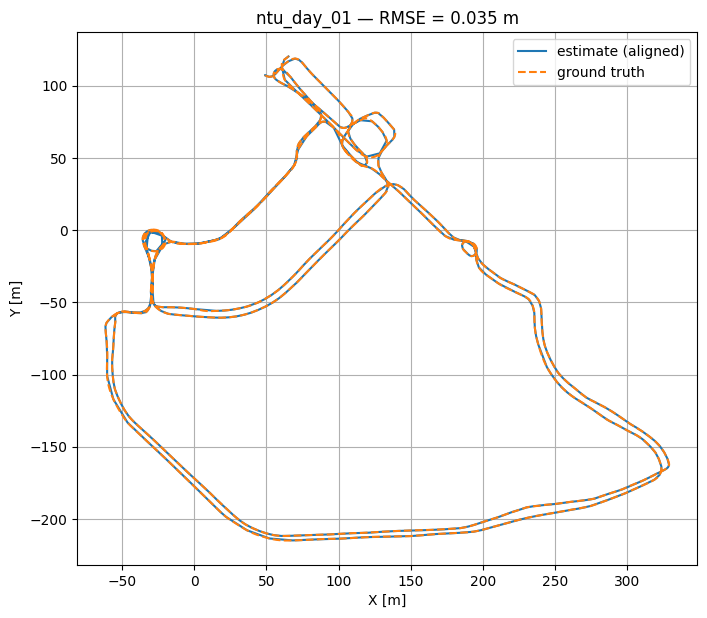

Processing set ntu_day_02...


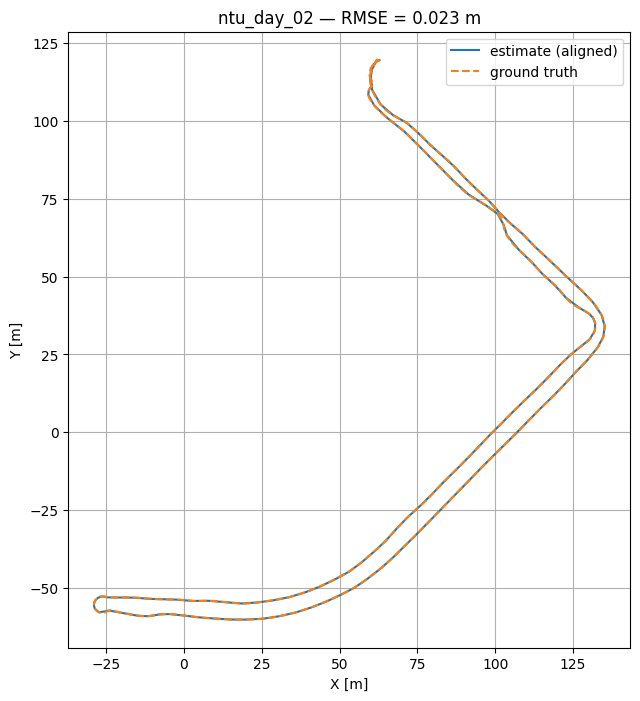

Processing set ntu_day_10...


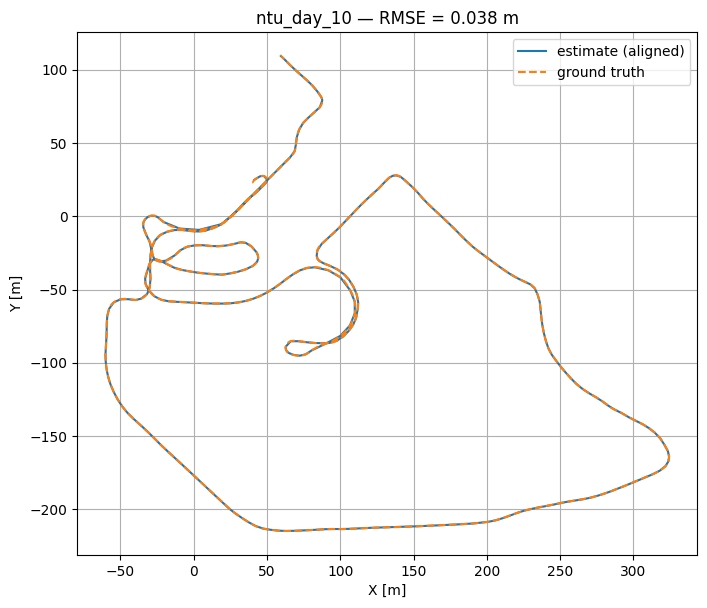

Processing set ntu_night_04...


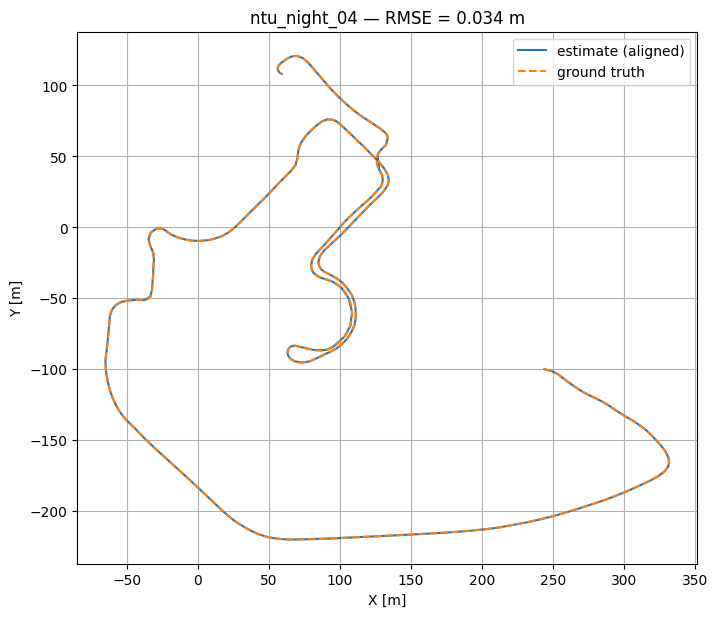

Processing set ntu_night_08...


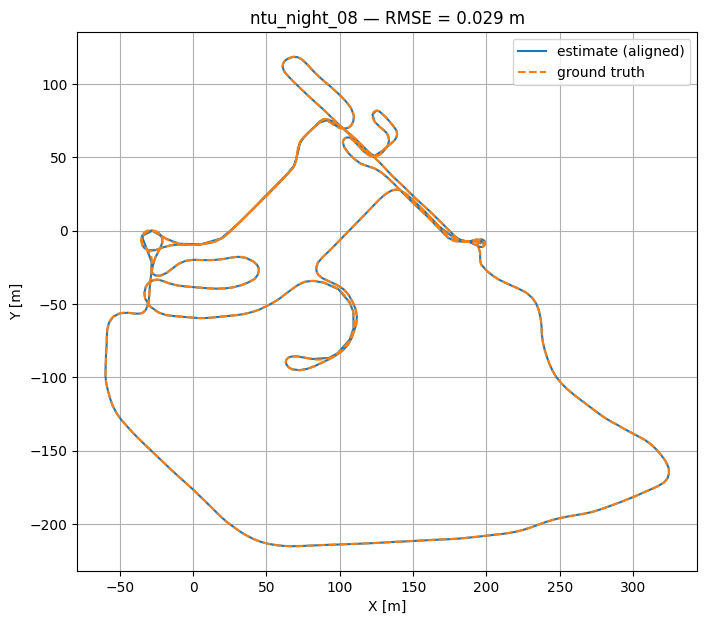

Processing set ntu_night_13...


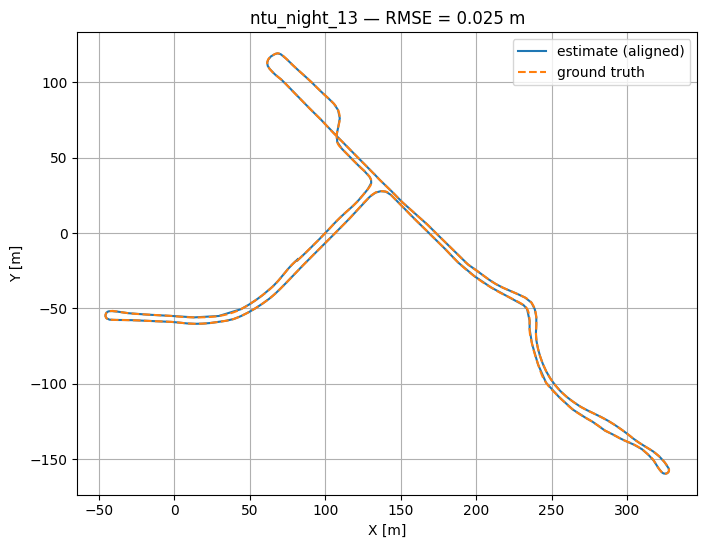


Summary of RMSE for all processed sets:
  ntu_day_01: 0.035 m
  ntu_day_02: 0.023 m
  ntu_day_10: 0.038 m
  ntu_night_04: 0.034 m
  ntu_night_08: 0.029 m
  ntu_night_13: 0.025 m


In [2]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt

from evo.core import metrics
import evo.core.sync as sync
import evo.core.trajectory as evotraj

# Paths to the directories containing estimate and ground truth
EST_DIR = '/home/dat/slict_ws/src/slict/evo/est'
GRT_DIR = '/home/dat/slict_ws/src/slict/evo/grt'

def load_estimate(est_path):
    """
    Load an estimated trajectory from a PCD file.
    - Skips the first 11 header lines.
    - Assumes columns: x y z intensity timestamp qx qy qz qw
    """
    data = np.loadtxt(est_path, delimiter=' ', skiprows=11)
    timestamps = data[:, 4]
    positions = data[:, 0:3]
    # Reorder quaternion to w,x,y,z
    quaternions = data[:, [8, 5, 6, 7]]
    return evotraj.PoseTrajectory3D(
        positions_xyz=positions,
        orientations_quat_wxyz=quaternions,
        timestamps=timestamps
    )

def load_groundtruth(grt_path):
    """
    Load a ground truth trajectory from a CSV file.
    - Skips the header line.
    - Assumes columns: 
        col 1: timestamp,
        cols 2-4: x, y, z,
        cols 5-8: qx, qy, qz, qw  (we reorder to w, x, y, z)
    """
    data = np.loadtxt(grt_path, delimiter=',', skiprows=1)
    timestamps = data[:, 1]
    positions = data[:, [2, 3, 4]]
    quaternions = data[:, [8, 5, 6, 7]]
    return evotraj.PoseTrajectory3D(
        positions_xyz=positions,
        orientations_quat_wxyz=quaternions,
        timestamps=timestamps
    )

def compute_rmse(traj_est, traj_gtr, max_diff=0.2):
    """
    Associate and align two trajectories, then compute translation RMSE.
    - max_diff: maximum timestamp difference (in seconds) for association
    """
    est_sync, gtr_sync = sync.associate_trajectories(
        traj_est, traj_gtr, max_diff=max_diff
    )
    est_sync.align(gtr_sync)
    ape_metric = metrics.APE(pose_relation=metrics.PoseRelation.translation_part)
    ape_metric.process_data((gtr_sync, est_sync))
    return float(
        ape_metric
        .get_result(ref_name='reference', est_name='estimate')
        .stats['rmse']
    )

def process_all_sets():
    # Find common subfolders in EST_DIR and GRT_DIR (e.g., ntu_day_01, ntu_day_02, ...)
    est_sets = [d for d in os.listdir(EST_DIR) if os.path.isdir(os.path.join(EST_DIR, d))]
    grt_sets = [d for d in os.listdir(GRT_DIR) if os.path.isdir(os.path.join(GRT_DIR, d))]
    common_sets = sorted(set(est_sets) & set(grt_sets))

    results = {}
    for subset in common_sets:
        # Locate .pcd and .csv files within each subfolder
        est_files = glob.glob(os.path.join(EST_DIR, subset, '*.pcd'))
        grt_files = glob.glob(os.path.join(GRT_DIR, subset, '*.csv'))

        if not est_files or not grt_files:
            print(f"[WARN] Skipping {subset}: missing .pcd or .csv file")
            continue

        est_path = est_files[0]  # take the first found estimate file
        grt_path = grt_files[0]  # take the first found ground truth file

        print(f"Processing set {subset}...")
        traj_est = load_estimate(est_path)
        traj_gtr = load_groundtruth(grt_path)
        rmse = compute_rmse(traj_est, traj_gtr)
        results[subset] = rmse

        # Optional: plot the aligned trajectories
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.plot(
            traj_est.positions_xyz[:, 0],
            traj_est.positions_xyz[:, 1],
            '-', label='estimate (aligned)'
        )
        ax.plot(
            traj_gtr.positions_xyz[:, 0],
            traj_gtr.positions_xyz[:, 1],
            '--', label='ground truth'
        )
        ax.set_aspect('equal')
        ax.set_title(f"{subset} — RMSE = {rmse:.3f} m")
        ax.set_xlabel('X [m]')
        ax.set_ylabel('Y [m]')
        ax.legend()
        ax.grid(True)
        plt.show()

    # Print summary of RMSE for all sets
    print("\nSummary of RMSE for all processed sets:")
    for subset, rmse_val in results.items():
        print(f"  {subset}: {rmse_val:.3f} m")

if __name__ == '__main__':
    process_all_sets()
